In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


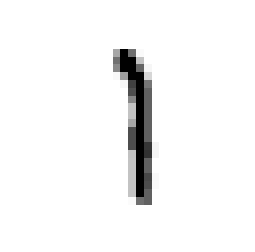

1.0


In [5]:
some_digit = X[12334]
some_digit_as_img = some_digit.reshape(28,28)

plt.imshow(some_digit_as_img, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
print(y[12334])

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Index mischeln**  
Damit bei der Kreuzvalidierung sämtliche Mengen ähnlich sind, müssen die Index gemischelt werden.

In [7]:
import numpy as np

In [8]:
shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binärer Klassifikator
Ein binärer Klassifikator kann genau **2 Kategorien** unterscheiden.

In unserem Beispiel **3 oder Nicht-3**

## Klassifikator für das stochastische Gradientenverfahren
Ein effizienter Klassifikator bei grossen Datensätzen, ausserdem geeignet für Online-Learning

In [9]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict(X_train[:10])

array([False, False,  True, False, False, False, False, False, False, False], dtype=bool)

# Qualitätsmasse bei Klassifikationen
Wir messen die Genauigkeit über die Kreuzvalidierung um das Problem beim Messen von Klassifikationen aufzuzeigen.  
Wie man sieht sind bei allen 6 durchläufen Genauigkeiten im Bereich 95% erzielt worden.  
Das Problem ist, das 90% der Datenpunkte Nicht-3 sind.
> Die **Genauigkeit** bei Klassifikatoren ist für gewöhnlich **nicht das empfehlenswerte Qualitätsmass**. Besonders dann nicht, wenn man es mit **unbalancierten Datensätzen** zu tun hat, sprich, Datensätze, bei denen manche Kategorien viel häufiger vorkommen als andere.  

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
# mit crossvalidation von sklearn
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([ 0.96940153,  0.9453    ,  0.94934747])

In [15]:
# eigene Implementierung der cross_validation
# die Folds sind in diesem Beispiel stratifiziert
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    
    # trainingsdaten
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    
    # validierungsdaten
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_3[test_index]
    
    # trainiere den klassifikator
    clone_clf.fit(X_train_folds, y_train_folds)
    
    # vorhersage treffen
    y_pred = clone_clf.predict(X_test_folds)
    
    # ergebniss berechnen
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.969401529924
0.9453
0.949347467373


# Konfusionsmatrix
* 00 -> richtige Negative:
    * Wurden richtig als Nicht-3en Klassifieziert
* 01 -> falsche Negative:
    * Wurden falsch als Nicht-3en Klassifiziert
* 10 -> falsche Positive:
    * Wurden falsch als 3en Klassiifiziert
* 11 -> richtige Positive:
    * Wurden richtig als 3en Klassifiziert

In [16]:
from sklearn.model_selection import cross_val_predict

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix(y_train_3, y_train_pred)

array([[52759,  1110],
       [ 1609,  4522]])

# Relevanz und Sensitivität (precision and recall)
Die Relevanz ist ein kompakteres Qualitätsmass welches die Genauigkeit der positiven Vorhersagen beschreibt.  
$Relevanz = \frac{RP}{RP + FP}$  
$RP =$ richtige Positive  
$FP =$ falsche Positive  

**Hohe Relevanz:**  
Verwirft viele gute Ergebnisse, aber zeigt bestimmt nur korrekte Ergebnisse an. Keine falschen Positiven, viele falsche Negative.  
**Hohe Sensitivität:**  
Umgekehrt. Keine falschen Negativen, viele falsche Positive. Verfehlt keine Positiven.  

$Sensitivität = \frac{RP}{RP + FN}$  
$FN =$ falsche Negative  

In [20]:
from sklearn.metrics import precision_score, recall_score

In [21]:
precision_score(y_train_3, y_train_pred)

0.80291193181818177

In [22]:
recall_score(y_train_3, y_train_pred)

0.73756320339259496

# $F_1$-Score
Mit diesem lassen sich zwei Klassifikatoren miteinander vergleichen.  
Er rechnet mit dem harmonischen Mittelwert, welchen auch niedrigen Mittelwerten ein hohes Gewicht verleiht.  
Der $F_1$-Score stellt zudem die Relevanz und die Sensitivität ins Verhältnis zueinander.

Achtung: Der $F_1$-Score begünstigt Klassifikatoren mit ähnlicher Relevanz und Sensitivität.

> Ein Erhöhen der Relevanz senkt die Sensitivität und umgekehrt. Dies nennt man auch die **Wechselbeziehung zwischen Relevanz und Sensitivität**.

# Wechselbeziehung zwischen Relevanz und Sensitivität

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-153172.67856833])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [25]:
threshold = -40000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [28]:
# berechnung aller scores
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train_3,
                             cv=3,
                             method='decision_function')
y_scores.shape

(60000, 2)

In [45]:
y_scores = y_scores[:,1]

In [46]:
# anzeige der relevanz und sensitivität anhand jedes berrechneten schwellwerts
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

In [47]:
# plotten
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(thresholds, precisions[:-1], 'b--', label='Relevanz')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Sensitivität')
    
    ax.set_xlabel('Schwellenwert')
    ax.legend(loc='center left')
    ax.set_ylim([-0.01,1.01])
    ax.set_xlim([thresholds.min(), thresholds.max()])
    ax.grid()

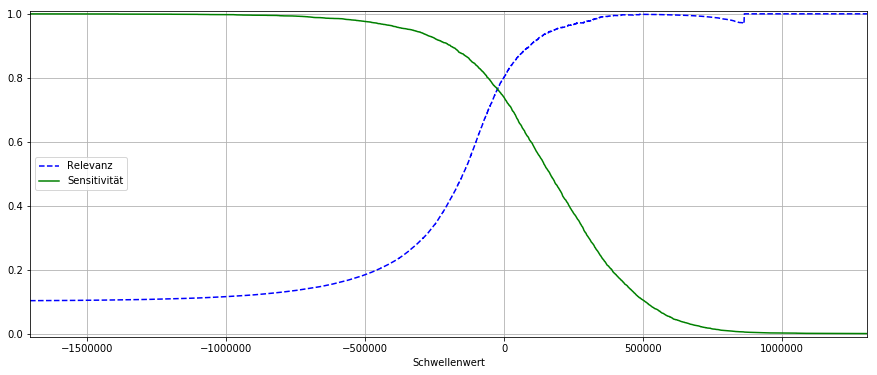

In [48]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [49]:
# relevanz gegen sensitivität
def plot_precision_vs_recall(precisions, recalls):
    fig, ax = plt.subplots(figsize=(9,7))
    ax.plot(recalls, precisions, 'g-', label='Relevanz vs. Sensitibität')
    
    major_ticks = np.arange(0, 1.2, 0.2)
    minor_ticks = np.arange(0, 1.05, 0.05)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    
    ax.set_xlabel('Sensitivität')
    ax.set_ylabel('Relevanz')
    ax.legend(loc='center left')
    ax.grid(which='major', alpha=0.5)
    ax.grid(which='minor', alpha=0.2)
    ax.set_title('Verhältniss')

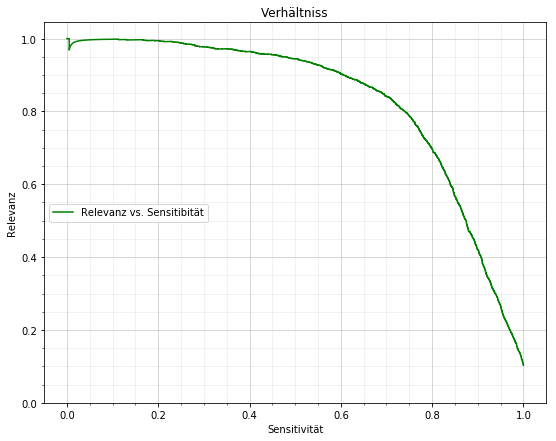

In [50]:
plot_precision_vs_recall(precisions, recalls)

In [51]:
# klassifiktator mit schwellewert bei 70'000 -> relevanz von 90% und sensitivität von 70%
y_train_pred_90 = (y_scores > 20000)

In [52]:
precision_score(y_train_3, y_train_pred_90)

0.832601641534644

In [53]:
recall_score(y_train_3, y_train_pred_90)

0.7114663187082042

# ROC-Kurve (Receiver Operating Characteristic)
Es werden für jeden Messpunkt die **Richtig-Positiv-Rate(=Sensitivität)** und die **Falsch-Positiv-Rate(=1-Spezifität)** gegenainander aufgetragen.  
**Richtig-Positiv-Rate(=Sensitivität):**  
$$\frac{RP}{RP+FN}$$

**Falsch-Positiv-Rate(=1-Spezifität):**  
$$1-\frac{RN}{RN+FP}$$


In [54]:
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

In [69]:
def plot_roc_curve(fpr, tpr,  label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0,1],[0,1], 'k--')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Falsch-Positiv-Rate(=1-Spezifität)')
    ax.set_ylabel('Richtig-Positiv-Rate(=Sensitivität)')
    return ax

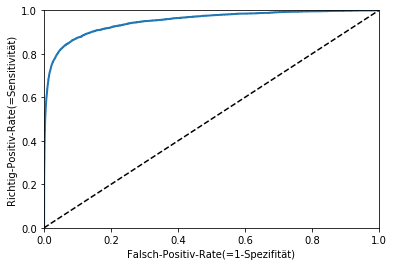

In [70]:
plot_roc_curve(fpr, tpr)

In [58]:
from sklearn.metrics import roc_auc_score

In [59]:
roc_auc_score(y_train_3, y_scores)

0.95089383292480145

# ROC- vs. PR-Kurve
**Wann sollte man welche Kurve benutzen?**  
Die **PR-Kurve** sollte man dann bevorzugen, wenn die positive Kategorie selten ist oder wenn die falsch Positiven wichtiger als die falsch Negativen sind.  

Andernfalls sollte man die **ROC-Kurve** verwenden.  

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3, method='predict_proba')

In [63]:
y_scores_forest = y_probas_forest[:,1] # score = Wahrscheinlichkeit der positiven Kategorie
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)

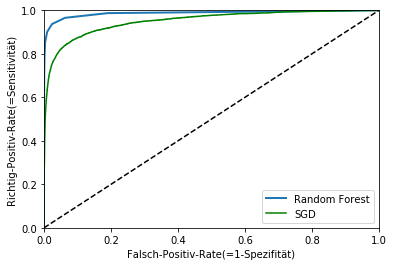

In [75]:
ax = plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
ax.plot(fpr, tpr,'g', label='SGD')
ax.legend(loc='lower right')

In [76]:
roc_auc_score(y_train_3, y_scores_forest)

0.98732978360223922

In [78]:
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(y_train_3, y_scores_forest)

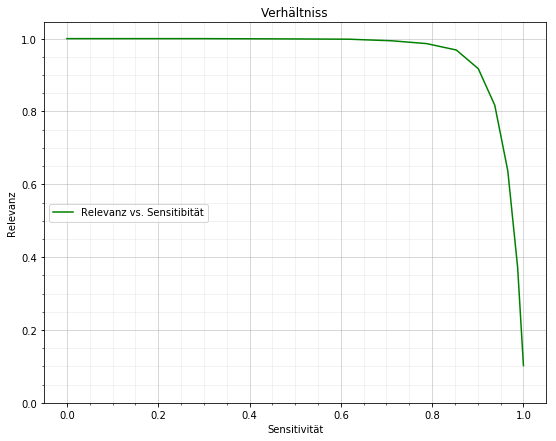

In [79]:
plot_precision_vs_recall(precision_forest, recall_forest)

In [81]:
# kreuzvalidierung zum auswerten
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)

In [82]:
precision_score(y_train_3, y_train_pred_forest)

0.98632094732543896

In [83]:
recall_score(y_train_3, y_train_pred_forest)

0.78796281193932471

# Klassifikatoren mit mehreren Kategorien / multinominale Klassifikatoren
Manche Algorithmen sind stets binäre Klassifikatoren (SVM-, Lineareklassifikatoren), während andere direkt mehrere Kategorien berücksichtigen können ( Bayes-, Random-Forest-Klassifikatoren).  

Man kann jedoch auch mit mehreren binären Klassifikatoren einen multinominalen Klassifikator erstellen. Hierfür gibt es zwei Strategien:  

**One-versus-all(OvA):**
Es werden für jede Kategorie ein binärer Klassifikator trainiert. Im Beispiel mit MNIST wäre das ein 1-Detektor, ein 2-Detektor usw.  
**One-versus-One(OvO):**  
Es werden für alle Kategorienpaare (hier Zahlenpaare 0/1, 1/2 usw.) ein Klassifikator trainiert der dieses Paar unterscheiden kann. Zum Klassifizieren muss der Input alle Klassifikatoren durchlaufen und derjenige mit der höchsten Wahrscheinlichkeit wird genommen.  
Anzahl Klassifikatoren: $$\frac{N * (N-1)}{2}$$
Der Vorteil von OvO liegt darin, dass jeder Klassifikator nur mit den Trainingsdaten der zu unterschiedenden Kategorien trainiert werden muss.  

Bei SVM-Klassifikatoren sollte die OvO-Strategie bevorzugt werden, da SVM schlecht mit grossen Datensätzen skaliert.

In [84]:
# scikit-learn erkennt selbst, wenn man einen binären Klassifikator für eine Aufgabe mit mehreren Klassifikatoren einsetzt.
# es wendet automatisch OvA an, ausser bei SVM OvO
sgd_clf.fit(X_train, y_train) # alle Daten
sgd_clf.predict([some_digit])

array([ 1.])

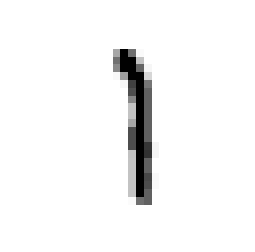

1.0


In [90]:
plt.imshow(some_digit_as_img, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
print(y[12334])

In [91]:
# Gibt für jede Kategorie einen Wert zurück, dieser  vom zutreffendem ist am höchsten
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[-694826.48091741,  115927.47582019, -130496.32366464,
        -153172.67856833, -399720.36373839, -181701.81048809,
        -226113.26032749,  -88228.93385091, -189801.21770067,
         -97281.71088874]])

In [92]:
np.argmax(some_digit_score)

1

In [93]:
# alle Kategorien
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [94]:
# möchte man sklearn eine andere Strategie aufzwingen, so kann man die Klassen OneVsOne bzw OneVsRestClassifier verwenden
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 1.])

In [96]:
len(ovo_clf.estimators_) # anzahl binärer Klassifikatoren

45

In [97]:
# Nun noch ein Beispiel mit einem RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 1.])

In [98]:
forest_clf.predict_proba([some_digit]) # ermittelt die Wahrscheinlichkeit für jede Kategorie

array([[ 0. ,  0.9,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ]])

In [99]:
# Kreuzvalidierung nach genauigkeit
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.8744751 ,  0.85514276,  0.86437966])

In [101]:
# Wenn wir die Eingaben skalieren erhalten wir ein viel besseres ergebnis
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([ 0.9105179 ,  0.90949547,  0.90848627])